# IMPORTS

In [5]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
from matplotlib import pyplot as plt
from tqdm import tqdm
import nltk
import re
from wordcloud import WordCloud
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
tqdm.pandas()


In [115]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\dpate\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dpate\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\dpate\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

# DATA PREPROCESSING & EXPLORATION

In [3]:
# review_df = pd.read_json('yelp_academic_dataset_review.json', lines=True, chunksize=50000)
# review_df = pd.concat(review_df, ignore_index=True)

# review_df.head()

# business_df = pd.read_json('yelp_academic_dataset_business.json', lines=True, chunksize=50000)
# business_df = pd.concat(business_df, ignore_index=True)
# filtered_business_df = business_df[business_df['state'] == 'PA']
# business_df.head()

# filtered_reviews = review_df[review_df['business_id'].isin(filtered_business_df['business_id'])]
# filtered_reviews.head()

# filtered_reviews.to_csv('filtered_reviews_PA.csv', index=False)

In [ ]:
df = pd.read_csv('filtered_reviews_PA.csv', chunksize=10000)
df = pd.concat(df, ignore_index=True)
df.shape
df.head()

In [ ]:
sample_raw_df = df.sample(frac=0.001, random_state=42)
sample_raw_df.to_csv('test_raw_sample_reviews_PA.csv', index=False)
print(sample_raw_df.shape)
sample_raw_df.head()

In [6]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Join tokens back into string
    return ' '.join(tokens)

In [7]:
# preprocessed_df = df.copy()
# preprocessed_df['text'] = preprocessed_df['text'].progress_apply(preprocess_text)
# preprocessed_df.head()

In [8]:
# preprocessed_df.to_csv('preprocessed_reviews_PA.csv', index=False)

In [ ]:
preprocessed_df = pd.read_csv('preprocessed_reviews_PA.csv')
print(preprocessed_df.shape)
preprocessed_df.head()

In [ ]:
# preprocessed_df.shape

# sample_df = preprocessed_df.sample(frac=0.1, random_state=42)
# sample_df.to_csv('sample_reviews_PA.csv', index=False)
# sample_df.head()

In [ ]:
sample_df = preprocessed_df.sample(frac=0.001, random_state=42)
sample_df.to_csv('test_sample_reviews_PA.csv', index=False)
print(sample_df.shape)
sample_df.head()

In [ ]:
useful = preprocessed_df['useful'].sum()
funny = preprocessed_df['funny'].sum()
cool = preprocessed_df['cool'].sum()

plt.figure(figsize=(10, 5))
plt.bar(['useful', 'funny', 'cool'], [useful, funny, cool])
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Count of useful, funny, and cool')
plt.show()


In [ ]:
pp_text = preprocessed_df['text']

# Define custom words to filter out
custom_stop_words = {'food', 'place', 'one', 'ive'}
# Filter out custom words from text
pp_text = pp_text.apply(lambda x: ' '.join([word for word in str(x).split() if word not in custom_stop_words]))


wordcloud = WordCloud(width=800, height=400, background_color='white').generate(pp_text.to_string())

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



In [ ]:
# Create scatter plots comparing text length vs useful/funny/cool votes
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,6))

# Calculate text lengths
text_lengths = preprocessed_df['text'].str.len()

# Calculate correlation coefficients
test_useful_corr = np.corrcoef(text_lengths.fillna(0), preprocessed_df['useful'].fillna(0))[0,1]
test_funny_corr = np.corrcoef(text_lengths.fillna(0), preprocessed_df['funny'].fillna(0))[0,1]
test_cool_corr = np.corrcoef(text_lengths.fillna(0), preprocessed_df['cool'].fillna(0))[0,1]

# Plot useful votes
ax1.scatter(text_lengths, preprocessed_df['useful'], color='red', alpha=0.5)
ax1.set_xlabel('Text Length')
ax1.set_ylabel('Number of Votes')
ax1.set_title(f'Useful Votes\nCorrelation: {test_useful_corr:.3f}')

# Plot funny votes
ax2.scatter(text_lengths, preprocessed_df['funny'], color='green', alpha=0.5)
ax2.set_xlabel('Text Length') 
ax2.set_ylabel('Number of Votes')
ax2.set_title(f'Funny Votes\nCorrelation: {test_funny_corr:.3f}')

# Plot cool votes
ax3.scatter(text_lengths, preprocessed_df['cool'], color='blue', alpha=0.5)
ax3.set_xlabel('Text Length')
ax3.set_ylabel('Number of Votes') 
ax3.set_title(f'Cool Votes\nCorrelation: {test_cool_corr:.3f}')

plt.tight_layout()
plt.show()

In [14]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

In [ ]:
pp_text_useful = preprocessed_df[preprocessed_df['useful'] > 0]['text']

# Remove any rows with NaN values
pp_text_useful = pp_text_useful.dropna()


top_ngrams = get_top_ngram(pp_text_useful, 3)
x,y=map(list,zip(*top_ngrams))
sns.barplot(x=y,y=x)

In [ ]:
top_ngrams = get_top_ngram(pp_text_useful, 2)
x,y=map(list,zip(*top_ngrams))
sns.barplot(x=y,y=x)

In [ ]:
pp_text_funny = preprocessed_df[preprocessed_df['funny'] > 0]['text']
pp_text_funny = pp_text_funny.dropna()

top_ngrams = get_top_ngram(pp_text_funny, 3)
x,y=map(list,zip(*top_ngrams))
sns.barplot(x=y,y=x)


In [ ]:
top_ngrams = get_top_ngram(pp_text_funny, 2)
x,y=map(list,zip(*top_ngrams))
sns.barplot(x=y,y=x)

In [ ]:
pp_text_cool = preprocessed_df[preprocessed_df['cool'] > 0]['text']
pp_text_cool = pp_text_cool.dropna()
top_ngrams = get_top_ngram(pp_text_cool, 3)
x,y=map(list,zip(*top_ngrams))
sns.barplot(x=y,y=x)


In [ ]:
top_ngrams = get_top_ngram(pp_text_cool, 2)
x,y=map(list,zip(*top_ngrams))
sns.barplot(x=y,y=x)

# MACHINE LEARNING MODEL

### Load Data

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using deivce: ', device)

Using deivce:  cuda


In [7]:
data_path = 'filtered_reviews_PA.csv'
df = pd.read_csv(data_path)
print(df.shape)
df.head()

(1598960, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
3,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31
4,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16


### Normalize Features & Drop Columns

In [8]:
df = df.drop(columns=['review_id', 'user_id', 'business_id', 'stars', 'date'])

In [30]:
sample_frac = 0.04

In [31]:
df['useful'] = (df['useful'] > 0).astype(int)
df['funny'] = (df['funny'] > 0).astype(int)
df['cool'] = (df['cool'] > 0).astype(int)

useful_df = df[['useful', 'text']]
funny_df = df[['funny', 'text']]
cool_df = df[['cool', 'text']]

useful_df = useful_df.sample(frac=sample_frac, random_state=42)
funny_df = funny_df.sample(frac=sample_frac, random_state=42)
cool_df = cool_df.sample(frac=sample_frac, random_state=42)

# df.head(30)

In [10]:
tagged_funny_df = funny_df.sample(frac=0.04, random_state=42)
tagged_cool_df = cool_df.sample(frac=0.04, random_state=42)
tagged_useful_df = useful_df.sample(frac=0.04, random_state=42)

# Apply POS tagging to the text columns in each tagged dataframe
tagged_funny_df['text'] = tagged_funny_df['text'].progress_apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))
tagged_cool_df['text'] = tagged_cool_df['text'].progress_apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))
tagged_useful_df['text'] = tagged_useful_df['text'].progress_apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))

100%|██████████| 63958/63958 [03:14<00:00, 329.48it/s]


In [32]:
test_df_useful, train_df_useful = train_test_split(useful_df, test_size=0.2, random_state=42)
test_df_funny, train_df_funny = train_test_split(funny_df, test_size=0.2, random_state=42)
test_df_cool, train_df_cool = train_test_split(cool_df, test_size=0.2, random_state=42)

In [11]:
test_df_tagged_funny, train_df_tagged_funny = train_test_split(tagged_funny_df, test_size=0.2, random_state=42)
test_df_tagged_cool, train_df_tagged_cool = train_test_split(tagged_cool_df, test_size=0.2, random_state=42)
test_df_tagged_useful, train_df_tagged_useful = train_test_split(tagged_useful_df, test_size=0.2, random_state=42)

In [33]:
# Process useful labels
train_text_useful = train_df_useful['text'].values.tolist()
train_labels_useful = train_df_useful['useful'].values.tolist()

test_text_useful = test_df_useful['text'].values.tolist()
test_labels_useful = test_df_useful['useful'].values.tolist()

# Process funny labels
train_text_funny = train_df_funny['text'].values.tolist()
train_labels_funny = train_df_funny['funny'].values.tolist()

test_text_funny = test_df_funny['text'].values.tolist()
test_labels_funny = test_df_funny['funny'].values.tolist()

# Process cool labels
train_text_cool = train_df_cool['text'].values.tolist()
train_labels_cool = train_df_cool['cool'].values.tolist()

test_text_cool = test_df_cool['text'].values.tolist()
test_labels_cool = test_df_cool['cool'].values.tolist()

In [12]:
# Process tagged useful labels
train_text_tagged_useful = train_df_tagged_useful['text'].values.tolist()
train_labels_tagged_useful = train_df_tagged_useful['useful'].values.tolist()

test_text_tagged_useful = test_df_tagged_useful['text'].values.tolist()
test_labels_tagged_useful = test_df_tagged_useful['useful'].values.tolist()

# Process tagged funny labels
train_text_tagged_funny = train_df_tagged_funny['text'].values.tolist()
train_labels_tagged_funny = train_df_tagged_funny['funny'].values.tolist()

test_text_tagged_funny = test_df_tagged_funny['text'].values.tolist()
test_labels_tagged_funny = test_df_tagged_funny['funny'].values.tolist()

# Process tagged cool labels
train_text_tagged_cool = train_df_tagged_cool['text'].values.tolist()
train_labels_tagged_cool = train_df_tagged_cool['cool'].values.tolist()

test_text_tagged_cool = test_df_tagged_cool['text'].values.tolist()
test_labels_tagged_cool = test_df_tagged_cool['cool'].values.tolist()

In [34]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

# Convert train_text_tagged_useful to a list of strings if it's not already
if isinstance(train_text_useful[0], tuple):
    train_text_useful = [' '.join([str(t) for t in text]) for text in train_text_useful]
    test_text_useful = [' '.join([str(t) for t in text]) for text in test_text_useful]
elif isinstance(train_text_useful[0], list):
    train_text_useful = [' '.join([str(t) for t in text]) for text in train_text_useful]
    test_text_useful = [' '.join([str(t) for t in text]) for text in test_text_useful]

train_encodings = tokenizer(train_text_useful, truncation=True, padding="max_length", max_length=512)
eval_encodings = tokenizer(test_text_useful, truncation=True, padding="max_length", max_length=512)

In [13]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

# Convert train_text_tagged_useful to a list of strings if it's not already
if isinstance(train_text_tagged_useful[0], tuple):
    train_text_tagged_useful = [' '.join([str(t) for t in text]) for text in train_text_tagged_useful]
    test_text_tagged_useful = [' '.join([str(t) for t in text]) for text in test_text_tagged_useful]
elif isinstance(train_text_tagged_useful[0], list):
    train_text_tagged_useful = [' '.join([str(t) for t in text]) for text in train_text_tagged_useful]
    test_text_tagged_useful = [' '.join([str(t) for t in text]) for text in test_text_tagged_useful]

# Convert train_text_tagged_funny to a list of strings if it's not already
# if isinstance(train_text_tagged_funny[0], tuple):
#     train_text_tagged_funny = [' '.join([str(t) for t in text]) for text in train_text_tagged_funny]
#     test_text_tagged_funny = [' '.join([str(t) for t in text]) for text in test_text_tagged_funny]
# elif isinstance(train_text_tagged_funny[0], list):
#     train_text_tagged_funny = [' '.join([str(t) for t in text]) for text in train_text_tagged_funny]
#     test_text_tagged_funny = [' '.join([str(t) for t in text]) for text in test_text_tagged_funny]

# # Convert train_text_tagged_cool to a list of strings if it's not already
# if isinstance(train_text_tagged_cool[0], tuple):
#     train_text_tagged_cool = [' '.join([str(t) for t in text]) for text in train_text_tagged_cool]
#     test_text_tagged_cool = [' '.join([str(t) for t in text]) for text in test_text_tagged_cool]
# elif isinstance(train_text_tagged_cool[0], list):
#     train_text_tagged_cool = [' '.join([str(t) for t in text]) for text in train_text_tagged_cool]
#     test_text_tagged_cool = [' '.join([str(t) for t in text]) for text in test_text_tagged_cool]

# Ensure all elements are strings
train_text_tagged_useful = [str(text) for text in train_text_tagged_useful]
test_text_tagged_useful = [str(text) for text in test_text_tagged_useful]
# train_text_tagged_funny = [str(text) for text in train_text_tagged_funny]
# test_text_tagged_funny = [str(text) for text in test_text_tagged_funny]
# train_text_tagged_cool = [str(text) for text in train_text_tagged_cool]
# test_text_tagged_cool = [str(text) for text in test_text_tagged_cool]

# Create encodings for all tagged datasets
tagged_train_encodings_useful = tokenizer(train_text_tagged_useful, truncation=True, padding="max_length", max_length=512)
tagged_eval_encodings_useful = tokenizer(test_text_tagged_useful, truncation=True, padding="max_length", max_length=512)

tagged_train_encodings_funny = tagged_train_encodings_useful
tagged_eval_encodings_funny = tagged_eval_encodings_useful

tagged_train_encodings_cool = tagged_train_encodings_useful
tagged_eval_encodings_cool = tagged_eval_encodings_useful

# tagged_train_encodings_funny = tokenizer(train_text_tagged_funny, truncation=True, padding="max_length", max_length=512)
# tagged_eval_encodings_funny = tokenizer(test_text_tagged_funny, truncation=True, padding="max_length", max_length=512)

# tagged_train_encodings_cool = tokenizer(train_text_tagged_cool, truncation=True, padding="max_length", max_length=512)
# tagged_eval_encodings_cool = tokenizer(test_text_tagged_cool, truncation=True, padding="max_length", max_length=512)

In [14]:
class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels  # Convert to list to avoid DataFrame issues

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)  # Changed to long tensor for single label
        return item

    def __len__(self):
        return len(self.labels)

In [15]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

def compute_metrics(p):
    predictions, labels = p.predictions, p.label_ids
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='binary')
    precision = precision_score(labels, predictions, average='binary')
    recall = recall_score(labels, predictions, average='binary')
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [35]:
train_dataset_funny = ReviewDataset(train_encodings, train_labels_funny)
eval_dataset_funny = ReviewDataset(eval_encodings, test_labels_funny)

train_dataset_cool = ReviewDataset(train_encodings, train_labels_cool)
eval_dataset_cool = ReviewDataset(eval_encodings, test_labels_cool)

train_dataset_useful = ReviewDataset(train_encodings, train_labels_useful)
eval_dataset_useful = ReviewDataset(eval_encodings, test_labels_useful)

In [16]:
# Create datasets with tagged data for useful, cool, and funny reviews
train_dataset_useful_tagged = ReviewDataset(tagged_train_encodings_useful, train_labels_tagged_useful)
eval_dataset_useful_tagged = ReviewDataset(tagged_eval_encodings_useful, test_labels_tagged_useful)

train_dataset_cool_tagged = ReviewDataset(tagged_train_encodings_cool, train_labels_tagged_cool)
eval_dataset_cool_tagged = ReviewDataset(tagged_eval_encodings_cool, test_labels_tagged_cool)

train_dataset_funny_tagged = ReviewDataset(tagged_train_encodings_funny, train_labels_tagged_funny)
eval_dataset_funny_tagged = ReviewDataset(tagged_eval_encodings_funny, test_labels_tagged_funny)

In [18]:
cool_bert = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased')
funny_bert = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased')
useful_bert = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased')
tagged_funny_bert = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased')
tagged_cool_bert = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased')
tagged_useful_bert = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased')


# Create an instance of TrainingArguments to configure the training process
training_args = TrainingArguments(
    output_dir='./results',  # Directory where the model predictions and checkpoints will be saved
    num_train_epochs=5,  # Number of times the model will be trained on the entire training dataset
    per_device_train_batch_size=16,  # Batch size for training on each device (GPU/CPU)
    per_device_eval_batch_size=16,  # Batch size for evaluation on each device
    warmup_steps=500,  # Number of steps for the learning rate warmup
    weight_decay=0.01,  # Weight decay to apply (if any) for regularization
    logging_dir='./logs',  # Directory for storing logs
    logging_steps=5000,  # Log training metrics every 5000 steps
    eval_strategy="epoch",  # Evaluation strategy to adopt during training (evaluate at the end of each epoch)
    save_strategy="epoch",  # Save strategy to adopt during training (save at the end of each epoch)
    load_best_model_at_end=True,  # Load the best model when finished training (based on evaluation metrics)
    gradient_accumulation_steps=2,  # Number of updates steps to accumulate before performing a backward/update pass
    fp16=True  # Enable mixed precision training
)

# funny_trainer = Trainer(
#     model=funny_bert,
#     args=training_args,
#     train_dataset=train_dataset_funny,
#     eval_dataset=eval_dataset_funny,
#     compute_metrics=compute_metrics
# )

# cool_trainer = Trainer(
#     model=cool_bert,
#     args=training_args,
#     train_dataset=train_dataset_cool,
#     eval_dataset=eval_dataset_cool,
#     compute_metrics=compute_metrics
# )

# useful_trainer = Trainer(
#     model=useful_bert,
#     args=training_args,
#     train_dataset=train_dataset_useful,
#     eval_dataset=eval_dataset_useful,
#     compute_metrics=compute_metrics
# )

tagged_cool_trainer = Trainer(
    model=tagged_cool_bert,
    args=training_args,
    train_dataset=train_dataset_cool_tagged,
    eval_dataset=eval_dataset_cool_tagged,
    compute_metrics=compute_metrics
)

tagged_funny_trainer = Trainer(
    model=tagged_funny_bert,
    args=training_args,
    train_dataset=train_dataset_funny_tagged,
    eval_dataset=eval_dataset_funny_tagged,
    compute_metrics=compute_metrics
)

tagged_useful_trainer = Trainer(
    model=tagged_useful_bert,
    args=training_args,
    train_dataset=train_dataset_useful_tagged,
    eval_dataset=eval_dataset_useful_tagged,
    compute_metrics=compute_metrics
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-strea

In [19]:
def evaluate_model(trainer, eval_dataset, title="Model Evaluation"):
    eval_preds = trainer.predict(eval_dataset)
    predictions = np.argmax(eval_preds.predictions, axis=1)
    labels = eval_preds.label_ids

    
    import seaborn as sns
    import matplotlib.pyplot as plt

    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print(classification_report(labels, predictions))

## Other

In [20]:
funny_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.439237,0.826519,0.000000,0.000000,0.000000
2,No log,0.442418,0.812267,0.223853,0.395817,0.156054
3,No log,0.475312,0.799861,0.232699,0.347414,0.174936
4,No log,0.677546,0.780700,0.241879,0.302140,0.201658


c:\git\wpi\nlp\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=4995, training_loss=0.34315807506725476, metrics={'train_runtime': 1986.4601, 'train_samples_per_second': 80.495, 'train_steps_per_second': 2.515, 'total_flos': 2.116299160928256e+16, 'train_loss': 0.34315807506725476, 'epoch': 4.995497748874437})

In [21]:
cool_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.524589,0.773867,0.000000,0.000000,0.000000
2,No log,0.505347,0.773875,0.000277,0.571429,0.000138
3,No log,0.526098,0.765995,0.187993,0.436563,0.119788
4,No log,0.682247,0.726680,0.288783,0.350830,0.245385


c:\git\wpi\nlp\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=4995, training_loss=0.448486181493994, metrics={'train_runtime': 1984.0255, 'train_samples_per_second': 80.594, 'train_steps_per_second': 2.518, 'total_flos': 2.116299160928256e+16, 'train_loss': 0.448486181493994, 'epoch': 4.995497748874437})

In [22]:
useful_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.669357,0.577926,0.654437,0.538085,0.834991
2,No log,0.664140,0.597118,0.516398,0.606886,0.449393
3,No log,0.665266,0.594625,0.507868,0.606176,0.436997
4,No log,0.753480,0.583922,0.554332,0.568768,0.540611


TrainOutput(global_step=4995, training_loss=0.6334070887293544, metrics={'train_runtime': 1987.4853, 'train_samples_per_second': 80.453, 'train_steps_per_second': 2.513, 'total_flos': 2.116299160928256e+16, 'train_loss': 0.6334070887293544, 'epoch': 4.995497748874437})

c:\git\wpi\nlp\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


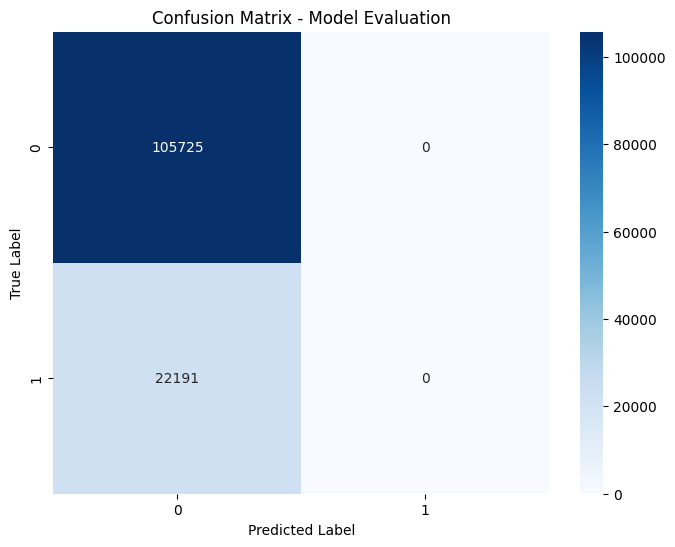

              precision    recall  f1-score   support

           0       0.83      1.00      0.91    105725
           1       0.00      0.00      0.00     22191

    accuracy                           0.83    127916
   macro avg       0.41      0.50      0.45    127916
weighted avg       0.68      0.83      0.75    127916



c:\git\wpi\nlp\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\git\wpi\nlp\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\git\wpi\nlp\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
evaluate_model(funny_trainer, eval_dataset_funny)

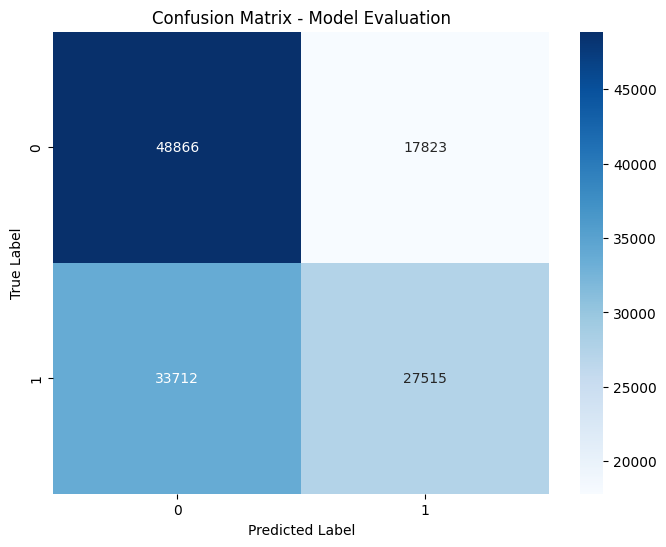

              precision    recall  f1-score   support

           0       0.59      0.73      0.65     66689
           1       0.61      0.45      0.52     61227

    accuracy                           0.60    127916
   macro avg       0.60      0.59      0.59    127916
weighted avg       0.60      0.60      0.59    127916



In [24]:
evaluate_model(useful_trainer, eval_dataset_useful)

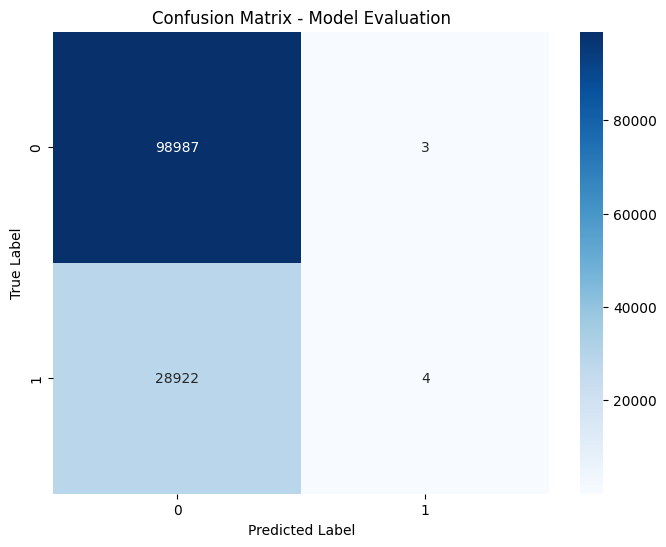

              precision    recall  f1-score   support

           0       0.77      1.00      0.87     98990
           1       0.57      0.00      0.00     28926

    accuracy                           0.77    127916
   macro avg       0.67      0.50      0.44    127916
weighted avg       0.73      0.77      0.68    127916



In [25]:
evaluate_model(cool_trainer, eval_dataset_cool)

In [26]:
# Save the trained models
funny_trainer.save_model("models/funny_model")
cool_trainer.save_model("models/cool_model") 
useful_trainer.save_model("models/useful_model")

# Save the tokenizer as well
tokenizer.save_pretrained("models/funny_model")
tokenizer.save_pretrained("models/cool_model")
tokenizer.save_pretrained("models/useful_model")

('models/useful_model\\tokenizer_config.json',
 'models/useful_model\\special_tokens_map.json',
 'models/useful_model\\vocab.txt',
 'models/useful_model\\added_tokens.json',
 'models/useful_model\\tokenizer.json')

In [27]:
# Get evaluation metrics for each model
funny_eval_metrics = funny_trainer.evaluate()
cool_eval_metrics = cool_trainer.evaluate()
useful_eval_metrics = useful_trainer.evaluate()

# Print the metrics
print("\nFunny Model Metrics:")
print(funny_eval_metrics)

print("\nCool Model Metrics:")
print(cool_eval_metrics)

print("\nUseful Model Metrics:")
print(useful_eval_metrics)


c:\git\wpi\nlp\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Funny Model Metrics:
{'eval_loss': 0.43923723697662354, 'eval_accuracy': 0.8265189655711561, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 205.2996, 'eval_samples_per_second': 623.07, 'eval_steps_per_second': 38.943, 'epoch': 4.995497748874437}

Cool Model Metrics:
{'eval_loss': 0.505347490310669, 'eval_accuracy': 0.7738750429969667, 'eval_f1': 0.0002765008813465593, 'eval_precision': 0.5714285714285714, 'eval_recall': 0.00013828389684021296, 'eval_runtime': 204.893, 'eval_samples_per_second': 624.306, 'eval_steps_per_second': 39.02, 'epoch': 4.995497748874437}

Useful Model Metrics:
{'eval_loss': 0.6641401648521423, 'eval_accuracy': 0.5971184214640858, 'eval_f1': 0.5163984422652841, 'eval_precision': 0.6068860558471922, 'eval_recall': 0.44939324154376337, 'eval_runtime': 206.3447, 'eval_samples_per_second': 619.914, 'eval_steps_per_second': 38.746, 'epoch': 4.995497748874437}


In [20]:
tagged_cool_trainer.train()
tagged_cool_trainer.save_model("models/tagged_cool_model")
tokenizer.save_pretrained("models/tagged_cool_model")

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.520344,0.776355,0.000000,0.000000,0.000000
2,No log,0.512067,0.776297,0.000000,0.000000,0.000000
3,No log,0.513124,0.763847,0.243820,0.429453,0.170235
4,No log,0.580938,0.750107,0.240827,0.375625,0.177226
5,No log,0.676347,0.731306,0.279001,0.348852,0.232457


c:\git\wpi\nlp\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


('models/tagged_cool_model\\tokenizer_config.json',
 'models/tagged_cool_model\\special_tokens_map.json',
 'models/tagged_cool_model\\vocab.txt',
 'models/tagged_cool_model\\added_tokens.json',
 'models/tagged_cool_model\\tokenizer.json')

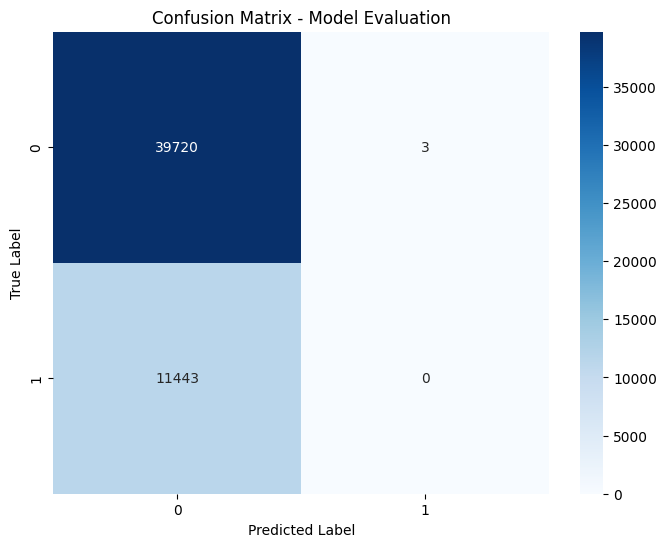

              precision    recall  f1-score   support

           0       0.78      1.00      0.87     39723
           1       0.00      0.00      0.00     11443

    accuracy                           0.78     51166
   macro avg       0.39      0.50      0.44     51166
weighted avg       0.60      0.78      0.68     51166



In [21]:
evaluate_model(tagged_cool_trainer, eval_dataset_cool_tagged)

In [22]:
tagged_funny_trainer.train()
tagged_funny_trainer.save_model("models/tagged_funny_model")
tokenizer.save_pretrained("models/tagged_funny_model")

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.455945,0.827034,0.000000,0.000000,0.000000
2,No log,0.437313,0.827034,0.000000,0.000000,0.000000
3,No log,0.451926,0.827014,0.000000,0.000000,0.000000
4,No log,0.487144,0.807958,0.205787,0.361442,0.143842
5,No log,0.567277,0.791483,0.243172,0.326663,0.193672


c:\git\wpi\nlp\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\git\wpi\nlp\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


('models/tagged_funny_model\\tokenizer_config.json',
 'models/tagged_funny_model\\special_tokens_map.json',
 'models/tagged_funny_model\\vocab.txt',
 'models/tagged_funny_model\\added_tokens.json',
 'models/tagged_funny_model\\tokenizer.json')

c:\git\wpi\nlp\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


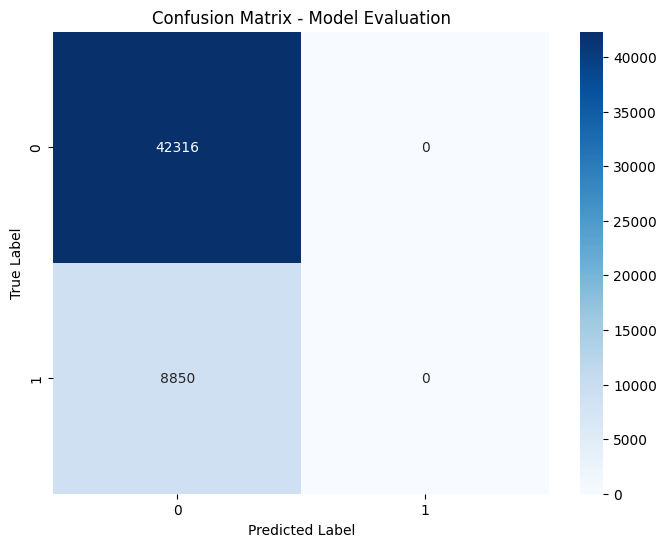

              precision    recall  f1-score   support

           0       0.83      1.00      0.91     42316
           1       0.00      0.00      0.00      8850

    accuracy                           0.83     51166
   macro avg       0.41      0.50      0.45     51166
weighted avg       0.68      0.83      0.75     51166



c:\git\wpi\nlp\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\git\wpi\nlp\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\git\wpi\nlp\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
evaluate_model(tagged_funny_trainer, eval_dataset_funny_tagged)


In [25]:
tagged_useful_trainer.train()
tagged_useful_trainer.save_model("models/tagged_useful_model")
tokenizer.save_pretrained("models/tagged_useful_model")

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.814399,0.570281,0.537320,0.555449,0.520337
2,No log,0.906855,0.564086,0.587116,0.537851,0.646316
3,No log,1.106314,0.562776,0.551351,0.542741,0.560238
4,No log,1.418214,0.556522,0.549218,0.535754,0.563376
5,No log,1.677738,0.554978,0.540353,0.535317,0.545484


('models/tagged_useful_model\\tokenizer_config.json',
 'models/tagged_useful_model\\special_tokens_map.json',
 'models/tagged_useful_model\\vocab.txt',
 'models/tagged_useful_model\\added_tokens.json',
 'models/tagged_useful_model\\tokenizer.json')

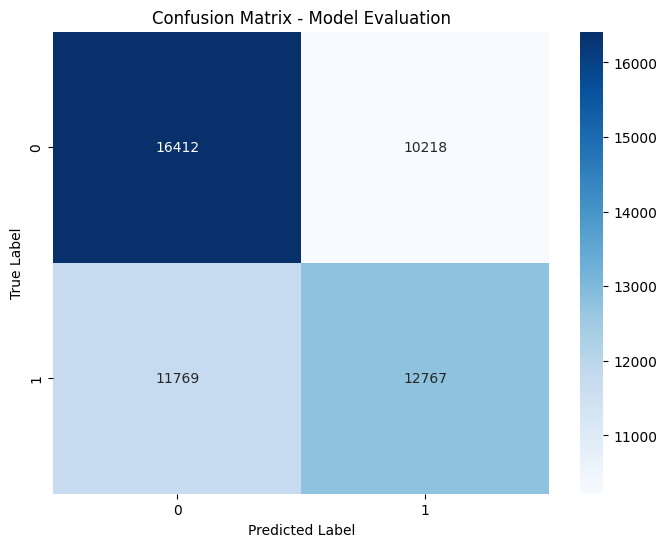

              precision    recall  f1-score   support

           0       0.58      0.62      0.60     26630
           1       0.56      0.52      0.54     24536

    accuracy                           0.57     51166
   macro avg       0.57      0.57      0.57     51166
weighted avg       0.57      0.57      0.57     51166



In [26]:
evaluate_model(tagged_useful_trainer, eval_dataset_useful_tagged)

In [105]:
# Get evaluation metrics for each tagged model
funny_tagged_eval_metrics = tagged_funny_trainer.evaluate()
cool_tagged_eval_metrics = tagged_cool_trainer.evaluate()
useful_tagged_eval_metrics = tagged_useful_trainer.evaluate()

# Print the metrics
print("\nTagged Funny Model Metrics:")
print(funny_tagged_eval_metrics)

print("\nTagged Cool Model Metrics:")
print(cool_tagged_eval_metrics)

print("\nTagged Useful Model Metrics:")
print(useful_tagged_eval_metrics)


c:\git\wpi\nlp\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


c:\git\wpi\nlp\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Tagged Funny Model Metrics:
{'eval_loss': 0.70068359375, 'eval_accuracy': 0.0, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 0.018, 'eval_samples_per_second': 55.524, 'eval_steps_per_second': 55.524, 'epoch': 5.0}

Tagged Cool Model Metrics:
{'eval_loss': 0.70751953125, 'eval_accuracy': 0.0, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 0.0223, 'eval_samples_per_second': 44.821, 'eval_steps_per_second': 44.821, 'epoch': 5.0}

Tagged Useful Model Metrics:
{'eval_loss': 0.68017578125, 'eval_accuracy': 1.0, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 0.0174, 'eval_samples_per_second': 57.372, 'eval_steps_per_second': 57.372, 'epoch': 5.0}


c:\git\wpi\nlp\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\git\wpi\nlp\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\git\wpi\nlp\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [106]:
# Save metrics to JSON files
import json

# Create a dictionary with all metrics
metrics_dict = {
    'funny_model': funny_eval_metrics,
    'cool_model': cool_eval_metrics,
    'useful_model': useful_eval_metrics,
    'tagged_funny_model': funny_tagged_eval_metrics,
    'tagged_cool_model': cool_tagged_eval_metrics,
    'tagged_useful_model': useful_tagged_eval_metrics
}

# Save to JSON files in their respective model directories
for model_name, metrics in metrics_dict.items():
    metrics_file = f"models/{model_name}/metrics.json"
    with open(metrics_file, 'w') as f:
        json.dump(metrics, f, indent=4)
    print(f"Saved metrics for {model_name} to {metrics_file}")


Saved metrics for funny_model to models/funny_model/metrics.json
Saved metrics for cool_model to models/cool_model/metrics.json
Saved metrics for useful_model to models/useful_model/metrics.json
Saved metrics for tagged_funny_model to models/tagged_funny_model/metrics.json
Saved metrics for tagged_cool_model to models/tagged_cool_model/metrics.json
Saved metrics for tagged_useful_model to models/tagged_useful_model/metrics.json


## Baseline Un-trained Model

In [38]:
# Create baseline models for each metric
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments
import torch
import json

# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Create baseline models
baseline_funny_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
baseline_cool_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
baseline_useful_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Create training arguments
training_args = TrainingArguments(
    output_dir='./results',  # Directory where the model predictions and checkpoints will be saved
    num_train_epochs=5,  # Number of times the model will be trained on the entire training dataset
    per_device_train_batch_size=16,  # Batch size for training on each device (GPU/CPU)
    per_device_eval_batch_size=16,  # Batch size for evaluation on each device
    warmup_steps=500,  # Number of steps for the learning rate warmup
    weight_decay=0.01,  # Weight decay to apply (if any) for regularization
    logging_dir='./logs',  # Directory for storing logs
    logging_steps=5000,  # Log training metrics every 5000 steps
    eval_strategy="epoch",  # Evaluation strategy to adopt during training (evaluate at the end of each epoch)
    save_strategy="epoch",  # Save strategy to adopt during training (save at the end of each epoch)
    load_best_model_at_end=True,  # Load the best model when finished training (based on evaluation metrics)
    gradient_accumulation_steps=2,  # Number of updates steps to accumulate before performing a backward/update pass
    fp16=True  # Enable mixed precision training
)

# Create trainers for each model
baseline_funny_trainer = Trainer(
    model=baseline_funny_model,
    args=training_args,
    train_dataset=train_dataset_funny,
    eval_dataset=eval_dataset_funny,
    compute_metrics=compute_metrics
)

baseline_cool_trainer = Trainer(
    model=baseline_cool_model,
    args=training_args,
    train_dataset=train_dataset_cool,
    eval_dataset=eval_dataset_cool,
    compute_metrics=compute_metrics
)

baseline_useful_trainer = Trainer(
    model=baseline_useful_model,
    args=training_args,
    train_dataset=train_dataset_useful,
    eval_dataset=eval_dataset_useful,
    compute_metrics=compute_metrics
)

# Save the baseline models
baseline_funny_model.save_pretrained('models/baseline_funny_model')
baseline_cool_model.save_pretrained('models/baseline_cool_model')
baseline_useful_model.save_pretrained('models/baseline_useful_model')

# Save the tokenizer
tokenizer.save_pretrained('models/baseline_funny_model')
tokenizer.save_pretrained('models/baseline_cool_model')
tokenizer.save_pretrained('models/baseline_useful_model')


# Get evaluation metrics for each baseline model
baseline_funny_eval_metrics = baseline_funny_trainer.evaluate()
baseline_cool_eval_metrics = baseline_cool_trainer.evaluate()
baseline_useful_eval_metrics = baseline_useful_trainer.evaluate()

# Print the metrics
print("\nBaseline Funny Model Metrics:")
print(baseline_funny_eval_metrics)

print("\nBaseline Cool Model Metrics:")
print(baseline_cool_eval_metrics)

print("\nBaseline Useful Model Metrics:")
print(baseline_useful_eval_metrics)



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-strea


Baseline Funny Model Metrics:
{'eval_loss': 0.6775043606758118, 'eval_model_preparation_time': 0.0016, 'eval_accuracy': 0.7791893053981159, 'eval_f1': 0.07408621537452877, 'eval_precision': 0.13484486873508353, 'eval_recall': 0.05107344632768362, 'eval_runtime': 82.0317, 'eval_samples_per_second': 623.734, 'eval_steps_per_second': 38.985}

Baseline Cool Model Metrics:
{'eval_loss': 0.7034768462181091, 'eval_model_preparation_time': 0.0016, 'eval_accuracy': 0.2988507993589493, 'eval_f1': 0.36304884327894466, 'eval_precision': 0.22780748663101605, 'eval_recall': 0.8934719916105917, 'eval_runtime': 81.8486, 'eval_samples_per_second': 625.13, 'eval_steps_per_second': 39.072}

Baseline Useful Model Metrics:
{'eval_loss': 0.6916060447692871, 'eval_model_preparation_time': 0.0016, 'eval_accuracy': 0.5303717312277685, 'eval_f1': 0.19648888145795018, 'eval_precision': 0.5472154963680388, 'eval_recall': 0.11974241930224976, 'eval_runtime': 81.7835, 'eval_samples_per_second': 625.627, 'eval_step

In [ ]:
# Save metrics to JSON files
metrics_dict = {
    'baseline_funny_model': baseline_funny_eval_metrics,
    'baseline_cool_model': baseline_cool_eval_metrics,
    'baseline_useful_model': baseline_useful_eval_metrics
}

# Save to JSON files in their respective model directories
for model_name, metrics in metrics_dict.items():
    metrics_file = f"models/{model_name}/metrics.json"
    with open(metrics_file, 'w') as f:
        json.dump(metrics, f, indent=4)
    print(f"Saved metrics for {model_name} to {metrics_file}")

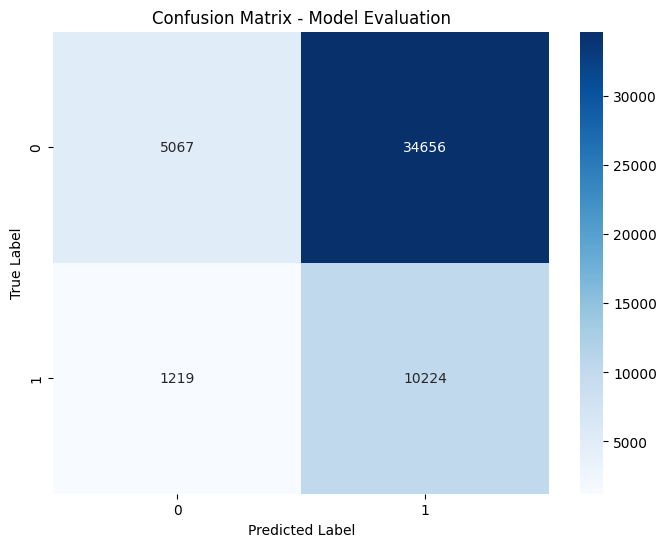

              precision    recall  f1-score   support

           0       0.81      0.13      0.22     39723
           1       0.23      0.89      0.36     11443

    accuracy                           0.30     51166
   macro avg       0.52      0.51      0.29     51166
weighted avg       0.68      0.30      0.25     51166



In [39]:
evaluate_model(baseline_cool_trainer, eval_dataset_cool)

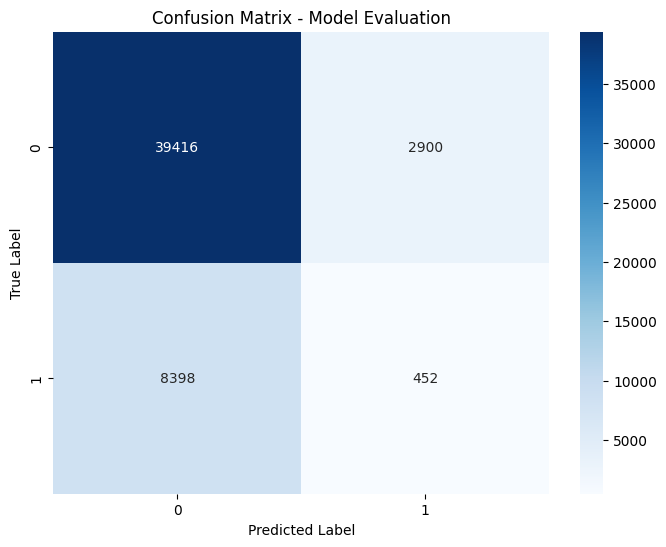

              precision    recall  f1-score   support

           0       0.82      0.93      0.87     42316
           1       0.13      0.05      0.07      8850

    accuracy                           0.78     51166
   macro avg       0.48      0.49      0.47     51166
weighted avg       0.71      0.78      0.74     51166



In [40]:
evaluate_model(baseline_funny_trainer, eval_dataset_funny)


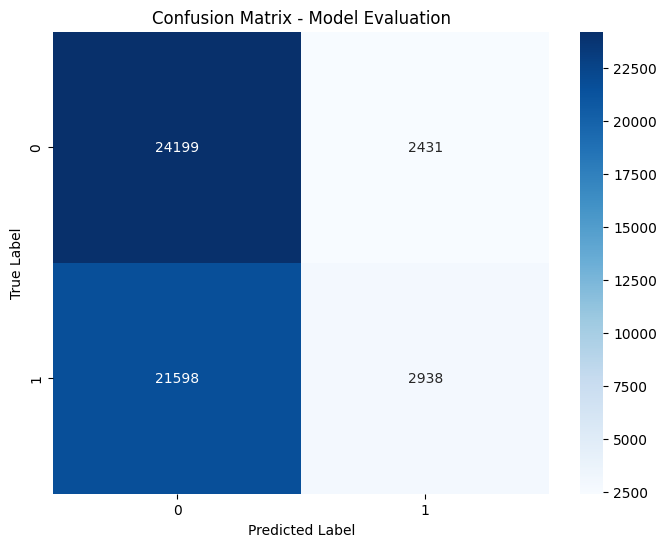

              precision    recall  f1-score   support

           0       0.53      0.91      0.67     26630
           1       0.55      0.12      0.20     24536

    accuracy                           0.53     51166
   macro avg       0.54      0.51      0.43     51166
weighted avg       0.54      0.53      0.44     51166



In [41]:
evaluate_model(baseline_useful_trainer, eval_dataset_useful)

## Code Gen

In [111]:
# Load the tokenizer and model
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
import torch

# Load the useful model and tokenizer
model_path = "models/useful_model"
model = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizer.from_pretrained(model_path)


In [112]:
# Create a dummy review
dummy_review = "I had an exceptional dining experience at this restaurant. The staff was incredibly attentive and knowledgeable about the menu. The chef's special pasta dish was cooked to perfection with a rich, flavorful sauce. The ambiance was cozy and perfect for a date night. I highly recommend trying their signature dessert - the chocolate lava cake was absolutely divine!"

# Tokenize the review
inputs = tokenizer(dummy_review, return_tensors="pt", truncation=True, max_length=512)

In [113]:
# Run inference
with torch.no_grad():
    outputs = model(**inputs)
    predictions = outputs.logits
    probs = np.argmax(predictions, axis=1)
    print(probs)
    score = probs[0]
    
# Print the prediction
# print(f"Review: {dummy_review}")
print(f"Usefulness score: {score:.2f}")

tensor([0])
Usefulness score: 0.00
